# Input data

In [1]:
import scipy.io as spio
import numpy as np

In [2]:
BahramFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFlipp.mat')
DJFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFlipp.mat')
NickFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFlipp.mat')
RoohiFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFlipp.mat')
SarahFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFlipp.mat')

In [3]:
FlippData = np.vstack(tup=(BahramFlipp['Intensification_Data'], 
                       DJFlipp['Intensification_Data'], 
                       NickFlipp['Intensification_Data'],
                      RoohiFlipp['Intensification_Data'],
                      SarahFlipp['Intensification_Data']))

In [4]:
FlippLabel = np.vstack(tup=(BahramFlipp['Intensification_Label'], 
                       DJFlipp['Intensification_Label'], 
                       NickFlipp['Intensification_Label'],
                      RoohiFlipp['Intensification_Label'],
                      SarahFlipp['Intensification_Label']))

In [5]:
(FlippData.shape, FlippData.dtype, FlippLabel.shape, FlippLabel.dtype)

((18900, 205, 16), dtype('<f8'), (18900, 1), dtype('uint8'))

In [6]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [7]:
# Standardize/normalize train and test
X_norm = normalize(inputs=FlippData)

In [8]:
# Deviding the input data into train and validation
# 30 % of data is test and the rest train
length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_norm[: -length]
X_valid_norm = X_norm[-length:]

# Output labels and classes

In [9]:
Y_train = np.array(FlippLabel[ :-length], dtype=int).reshape(-1)
Y_valid = np.array(FlippLabel[-length: ], dtype=int).reshape(-1)

In [10]:
(X_train_norm.shape, X_train_norm.dtype, Y_train.shape, Y_train.dtype)

((13230, 205, 16), dtype('<f8'), (13230,), dtype('int64'))

### Hyperparameters

In [11]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = Y_train.max() + 1

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [12]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)

In [13]:
(Y_train_onehot.shape, Y_valid_onehot.shape, X_train_norm.shape, X_valid_norm.shape)

((13230, 2), (5670, 2), (13230, 205, 16), (5670, 205, 16))

# GPUs or CPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [15]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [16]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap and 60% overlapping window
out_conv = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=5, strides=2, padding='valid', 
                            activation = tf.nn.relu)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 101*32) --> (batch, 101*32*2)
# 101*32 = 202 + 3030 = 3232*2 = 6464
in_fc = tf.reshape(out_conv, (-1, 101*32))
out_fc = tf.layers.dense(inputs=in_fc, units=101*32*2, activation=tf.nn.relu)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 101*32*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 3232) (?, 6464)
(?, 2)


In [17]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [18]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation full-batch 
            # no dropout/keep_prob; no learning rate/ no learning
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Print at each iter/ epoch
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(train_loss),
                  "Valid loss: {:.6f}".format(valid_loss),
                  "train acc: {:.6f}".format(train_acc),
                  "Valid acc: {:.6f}".format(valid_acc))

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

Epoch: 1/5 Train loss: 0.617726 Valid loss: 9.200819 train acc: 0.696970 Valid acc: 0.833333
Epoch: 1/5 Train loss: 5.628671 Valid loss: 6.724473 train acc: 0.833333 Valid acc: 0.833333
Epoch: 1/5 Train loss: 4.288337 Valid loss: 2.763451 train acc: 0.833333 Valid acc: 0.833333
Epoch: 1/5 Train loss: 1.881740 Valid loss: 0.675893 train acc: 0.833333 Valid acc: 0.624868
Epoch: 1/5 Train loss: 0.406530 Valid loss: 4.735325 train acc: 0.825758 Valid acc: 0.166667
Epoch: 1/5 Train loss: 2.406171 Valid loss: 1.955158 train acc: 0.166667 Valid acc: 0.170018
Epoch: 1/5 Train loss: 1.080186 Valid loss: 0.494491 train acc: 0.287879 Valid acc: 0.832804
Epoch: 1/5 Train loss: 0.452222 Valid loss: 0.930208 train acc: 0.840909 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.557705 Valid loss: 1.224190 train acc: 0.833333 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.767548 Valid loss: 1.306541 train acc: 0.833333 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.785413 Valid loss: 1.234672 train acc: 0.8333

Epoch: 1/5 Train loss: 0.457640 Valid loss: 0.569204 train acc: 0.833333 Valid acc: 0.832275
Epoch: 1/5 Train loss: 0.441832 Valid loss: 0.563850 train acc: 0.840909 Valid acc: 0.832452
Epoch: 1/5 Train loss: 0.461190 Valid loss: 0.548811 train acc: 0.818182 Valid acc: 0.832275
Epoch: 1/5 Train loss: 0.461802 Valid loss: 0.531197 train acc: 0.833333 Valid acc: 0.831923
Epoch: 1/5 Train loss: 0.416503 Valid loss: 0.511431 train acc: 0.825758 Valid acc: 0.831393
Epoch: 1/5 Train loss: 0.444600 Valid loss: 0.495058 train acc: 0.825758 Valid acc: 0.829806
Epoch: 1/5 Train loss: 0.467670 Valid loss: 0.487006 train acc: 0.818182 Valid acc: 0.827690
Epoch: 1/5 Train loss: 0.394462 Valid loss: 0.485519 train acc: 0.871212 Valid acc: 0.828748
Epoch: 1/5 Train loss: 0.416405 Valid loss: 0.487911 train acc: 0.810606 Valid acc: 0.832452
Epoch: 1/5 Train loss: 0.433336 Valid loss: 0.495349 train acc: 0.833333 Valid acc: 0.833686
Epoch: 1/5 Train loss: 0.500276 Valid loss: 0.503534 train acc: 0.8106

Epoch: 2/5 Train loss: 0.279860 Valid loss: 0.626239 train acc: 0.901515 Valid acc: 0.824162
Epoch: 2/5 Train loss: 0.476874 Valid loss: 0.619055 train acc: 0.825758 Valid acc: 0.824515
Epoch: 2/5 Train loss: 0.330196 Valid loss: 0.608971 train acc: 0.871212 Valid acc: 0.824162
Epoch: 2/5 Train loss: 0.299149 Valid loss: 0.595994 train acc: 0.901515 Valid acc: 0.823810
Epoch: 2/5 Train loss: 0.256969 Valid loss: 0.587321 train acc: 0.909091 Valid acc: 0.823281
Epoch: 2/5 Train loss: 0.300095 Valid loss: 0.576780 train acc: 0.901515 Valid acc: 0.820282
Epoch: 2/5 Train loss: 0.261594 Valid loss: 0.570163 train acc: 0.901515 Valid acc: 0.818519
Epoch: 2/5 Train loss: 0.326988 Valid loss: 0.569415 train acc: 0.878788 Valid acc: 0.818166
Epoch: 2/5 Train loss: 0.388671 Valid loss: 0.571563 train acc: 0.833333 Valid acc: 0.817637
Epoch: 2/5 Train loss: 0.458606 Valid loss: 0.574567 train acc: 0.795455 Valid acc: 0.819577
Epoch: 2/5 Train loss: 0.461629 Valid loss: 0.575235 train acc: 0.8106

Epoch: 3/5 Train loss: 0.266618 Valid loss: 0.635457 train acc: 0.916667 Valid acc: 0.821870
Epoch: 3/5 Train loss: 0.321362 Valid loss: 0.645053 train acc: 0.909091 Valid acc: 0.822399
Epoch: 3/5 Train loss: 0.365048 Valid loss: 0.655218 train acc: 0.863636 Valid acc: 0.824162
Epoch: 3/5 Train loss: 0.291277 Valid loss: 0.670134 train acc: 0.916667 Valid acc: 0.825750
Epoch: 3/5 Train loss: 0.485008 Valid loss: 0.666819 train acc: 0.833333 Valid acc: 0.825397
Epoch: 3/5 Train loss: 0.199728 Valid loss: 0.665769 train acc: 0.916667 Valid acc: 0.825750
Epoch: 3/5 Train loss: 0.305844 Valid loss: 0.659114 train acc: 0.893939 Valid acc: 0.825044
Epoch: 3/5 Train loss: 0.287980 Valid loss: 0.654540 train acc: 0.886364 Valid acc: 0.824691
Epoch: 3/5 Train loss: 0.226736 Valid loss: 0.655937 train acc: 0.924242 Valid acc: 0.824339
Epoch: 3/5 Train loss: 0.242918 Valid loss: 0.666155 train acc: 0.893939 Valid acc: 0.825750
Epoch: 3/5 Train loss: 0.501165 Valid loss: 0.670109 train acc: 0.8333

Epoch: 4/5 Train loss: 0.214230 Valid loss: 0.633973 train acc: 0.901515 Valid acc: 0.822928
Epoch: 4/5 Train loss: 0.266539 Valid loss: 0.625754 train acc: 0.901515 Valid acc: 0.820635
Epoch: 4/5 Train loss: 0.316044 Valid loss: 0.618322 train acc: 0.840909 Valid acc: 0.817813
Epoch: 4/5 Train loss: 0.200427 Valid loss: 0.623105 train acc: 0.924242 Valid acc: 0.818519
Epoch: 4/5 Train loss: 0.333653 Valid loss: 0.632317 train acc: 0.893939 Valid acc: 0.820459
Epoch: 4/5 Train loss: 0.327073 Valid loss: 0.639026 train acc: 0.871212 Valid acc: 0.821517
Epoch: 4/5 Train loss: 0.264668 Valid loss: 0.646432 train acc: 0.893939 Valid acc: 0.821870
Epoch: 4/5 Train loss: 0.368893 Valid loss: 0.647265 train acc: 0.863636 Valid acc: 0.822222
Epoch: 4/5 Train loss: 0.306579 Valid loss: 0.641229 train acc: 0.871212 Valid acc: 0.819753
Epoch: 4/5 Train loss: 0.308357 Valid loss: 0.637195 train acc: 0.863636 Valid acc: 0.818695
Epoch: 4/5 Train loss: 0.278692 Valid loss: 0.638598 train acc: 0.9015

Epoch: 5/5 Train loss: 0.178445 Valid loss: 0.644854 train acc: 0.939394 Valid acc: 0.810582
Epoch: 5/5 Train loss: 0.154463 Valid loss: 0.641148 train acc: 0.969697 Valid acc: 0.811993
Epoch: 5/5 Train loss: 0.208159 Valid loss: 0.638460 train acc: 0.931818 Valid acc: 0.812875
Epoch: 5/5 Train loss: 0.291735 Valid loss: 0.638095 train acc: 0.871212 Valid acc: 0.813580
Epoch: 5/5 Train loss: 0.129311 Valid loss: 0.646733 train acc: 0.977273 Valid acc: 0.817284
Epoch: 5/5 Train loss: 0.273612 Valid loss: 0.652980 train acc: 0.909091 Valid acc: 0.819224
Epoch: 5/5 Train loss: 0.304306 Valid loss: 0.653400 train acc: 0.871212 Valid acc: 0.819224
Epoch: 5/5 Train loss: 0.166096 Valid loss: 0.658782 train acc: 0.946970 Valid acc: 0.821164
Epoch: 5/5 Train loss: 0.244602 Valid loss: 0.664592 train acc: 0.916667 Valid acc: 0.822575
Epoch: 5/5 Train loss: 0.196240 Valid loss: 0.668431 train acc: 0.924242 Valid acc: 0.822928
Epoch: 5/5 Train loss: 0.176938 Valid loss: 0.666948 train acc: 0.9318

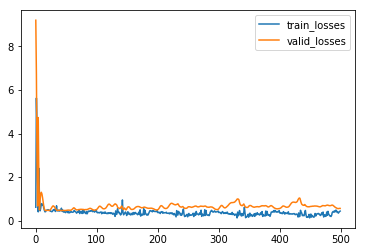

In [19]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

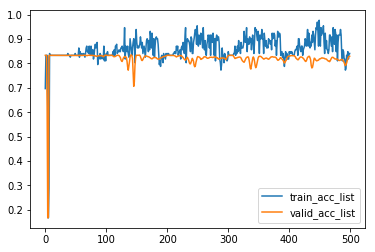

In [20]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()